In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
def load_data(file_path):
    try:
        df = pd.read_csv(f"{file_path}")
        print("Dataset loaded successfully")
        return df
    except FileNotFoundError:
        # Handle missing file
        print("Error: CSV file not found")
        return None
    except Exception as e:
        # Handle other errors
        print(f"Error loading dataset: {e}")
        return None

districts = load_data("final_ds/District_Level_Stats.csv")
schools = load_data("final_ds/School_Info.csv")
students = load_data("final_ds/Student_Records.csv")
teachers = load_data("final_ds/Teacher_Deployment.csv")


Dataset loaded successfully
Dataset loaded successfully
Dataset loaded successfully
Dataset loaded successfully


In [3]:
students.isnull().sum()

Student_ID                 0
District                   0
School_ID                  0
Grade                      0
Gender                     0
Socioeconomic_Status       0
Attendance_Rate         2453
Previous_Year_GPA          0
Dropout_Status             0
dtype: int64

In [4]:
# imputing the null values in Student's attendance rate using median

students['Attendance_Rate'] = students['Attendance_Rate'].fillna(students['Attendance_Rate'].median())

In [5]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   School_ID             500 non-null    object 
 1   District              500 non-null    object 
 2   Location_Type         500 non-null    object 
 3   Infrastructure_Score  500 non-null    float64
 4   Electricity_Access    500 non-null    object 
 5   Internet_Access       500 non-null    object 
 6   Library_Status        500 non-null    object 
dtypes: float64(1), object(6)
memory usage: 27.5+ KB


In [6]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            50000 non-null  object 
 1   District              50000 non-null  object 
 2   School_ID             50000 non-null  object 
 3   Grade                 50000 non-null  int64  
 4   Gender                50000 non-null  object 
 5   Socioeconomic_Status  50000 non-null  object 
 6   Attendance_Rate       50000 non-null  float64
 7   Previous_Year_GPA     50000 non-null  float64
 8   Dropout_Status        50000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB


In [7]:
# dropping District col in students as it already exists in school df, which will create conflict in merging dataset later on
students = students.drop(columns=['District'])

In [8]:
# function to plot bar charts for categorical cols

def plot_categorical_bar_charts(df, df_name, columns):
    """
    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): A list of categorical column names to create bar charts for.
    """
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    pastel_colors = sns.color_palette("pastel")

    for i, col in enumerate(columns):
        if col in df.columns:
            # Plot bar chart using countplot
            sns.countplot(data=df, x=col, hue=col, ax=axes[i], palette="pastel", legend=True)

            axes[i].set_title(f"Distribution of {df_name}'s {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
            # Add text labels on the bars
            for container in axes[i].containers:
                axes[i].bar_label(container)
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame.")
            axes[i].axis('off')

    # Hide any remaining unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
# function to plot histogram for continuous cols


def plot_histograms_with_kde(df, df_name, columns, n_bins):
    """
    Plot histograms with KDE curves for selected numerical columns using Seaborn subplots.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of specific numerical column names to plot.
    """
    # Filter out non-existent or non-numeric columns
    valid_columns = columns

    if not valid_columns:
        print("No valid columns found.")
        return

    n_cols = 2
    n_rows = -(-len(valid_columns) // n_cols)  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(valid_columns):
        sns.set_palette("pastel")

         # Plot histogram
        sns.histplot(data=df, x=col, ax=axes[i], color='lightblue', bins=n_bins, stat='density')
        # Overlay KDE curve
        sns.kdeplot(data=df, x=col, ax=axes[i], color='red', linewidth=2)

        axes[i].set_title(f"Distribution of {df_name}'s {col}")
        axes[i].set_ylabel('Count')

    # Hide unused axes
    for j in range(len(valid_columns), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


# **1. Understanding individual datasets**

## **School Info**

In [12]:
schools.head()

,School_ID,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status
0,SCH001,Rasuwa,Rural,1.2,Y,Y,N
1,SCH002,Chitwan,Rural,2.2,N,Y,N
2,SCH003,Bhaktapur,Rural,1.6,Y,N,N
3,SCH004,Sindhuli,Rural,1.6,Y,N,Y
4,SCH005,Kathmandu,Urban,2.9,Y,Y,Y


In [13]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   School_ID             500 non-null    object 
 1   District              500 non-null    object 
 2   Location_Type         500 non-null    object 
 3   Infrastructure_Score  500 non-null    float64
 4   Electricity_Access    500 non-null    object 
 5   Internet_Access       500 non-null    object 
 6   Library_Status        500 non-null    object 
dtypes: float64(1), object(6)
memory usage: 27.5+ KB


In [14]:
schools.describe()

,Infrastructure_Score
count,500.000000
mean,2.488400
std,1.005588
min,1.000000
25%,1.775000
50%,2.300000
75%,3.100000
max,5.000000


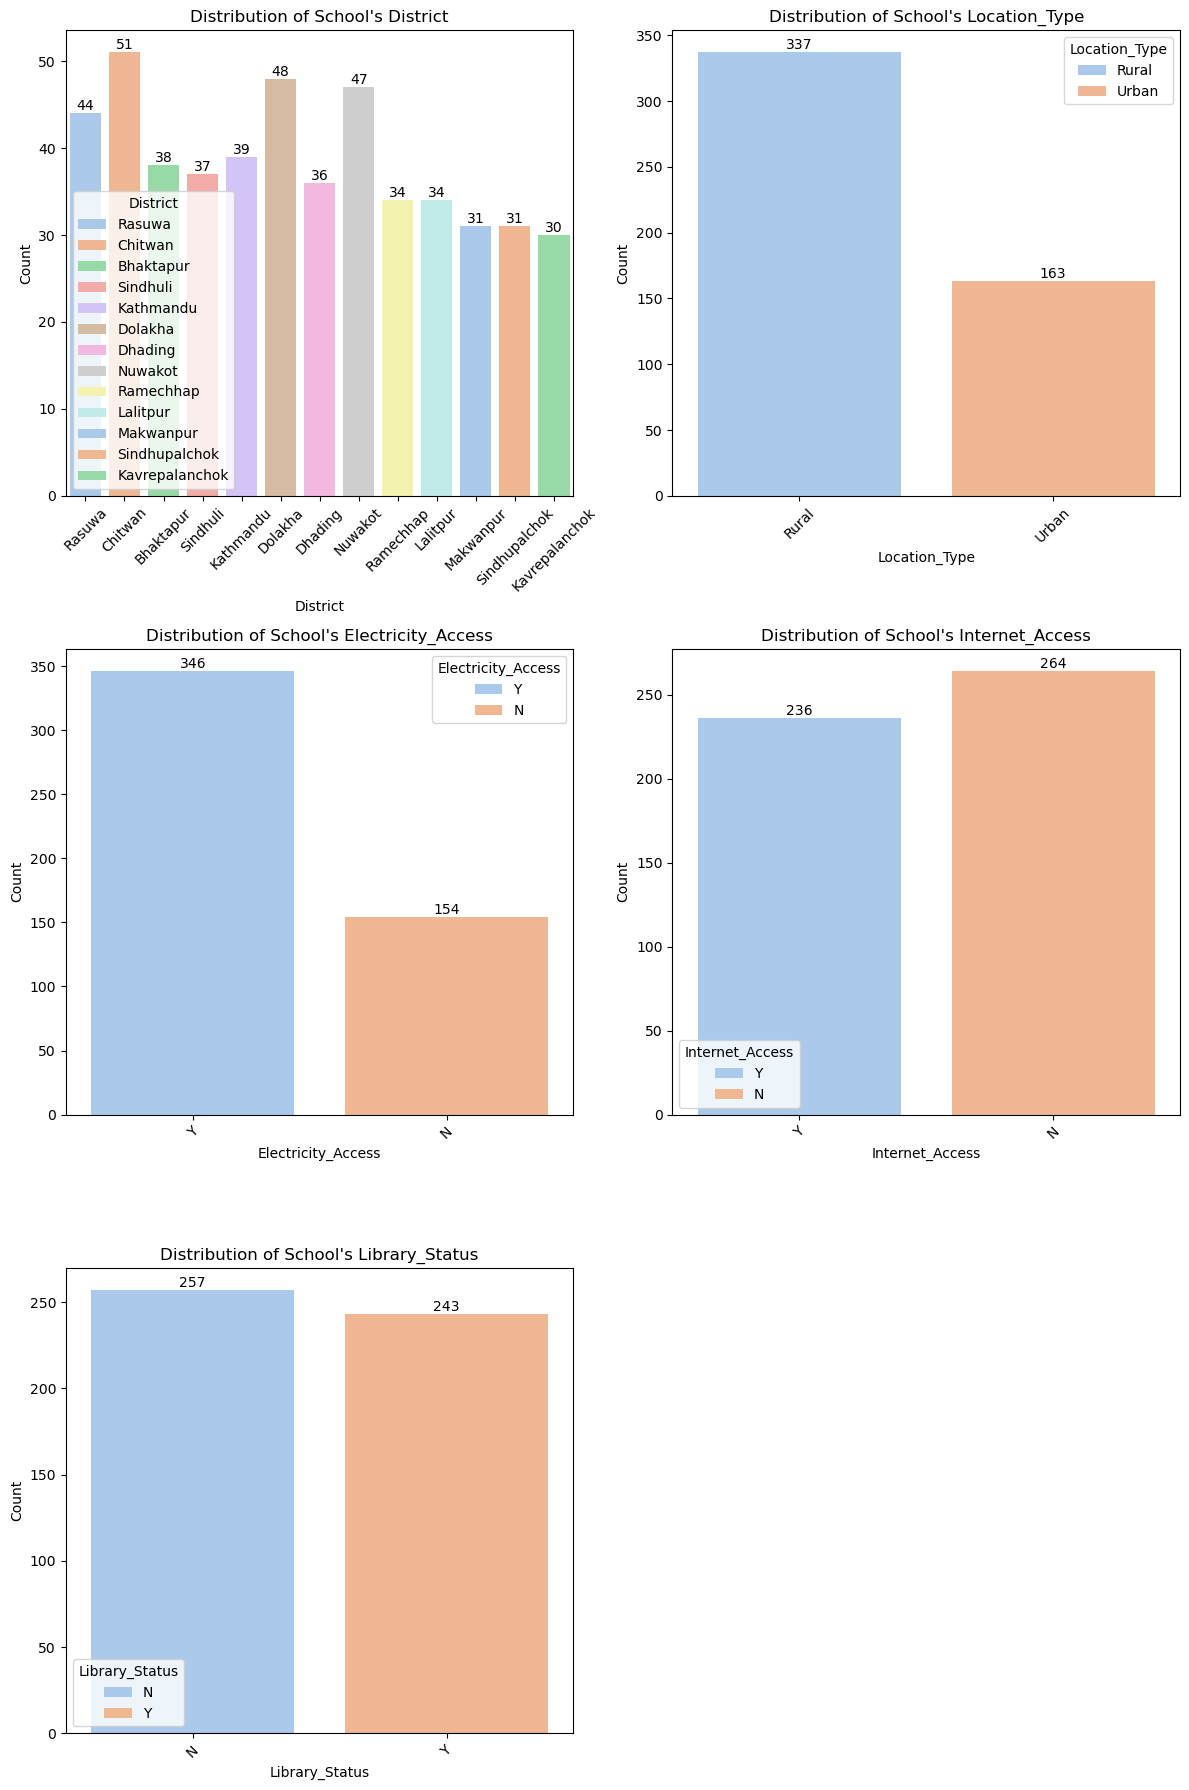

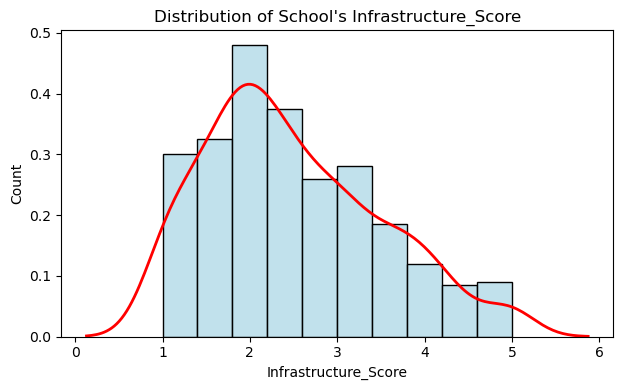

In [15]:
# bar chart for visualizing school info

# Specify the categorical columns
categorical_columns_to_plot = [
    'District',
    'Location_Type',
    'Electricity_Access',
    'Internet_Access',
    'Library_Status'
]

# plot the bar charts for school info's categorical columns
plot_categorical_bar_charts(schools, 'School', categorical_columns_to_plot)



# Histogram for visualizing continous values of school info

selected_cols= ['Infrastructure_Score']
plot_histograms_with_kde(schools, 'School', selected_cols, n_bins = 10)

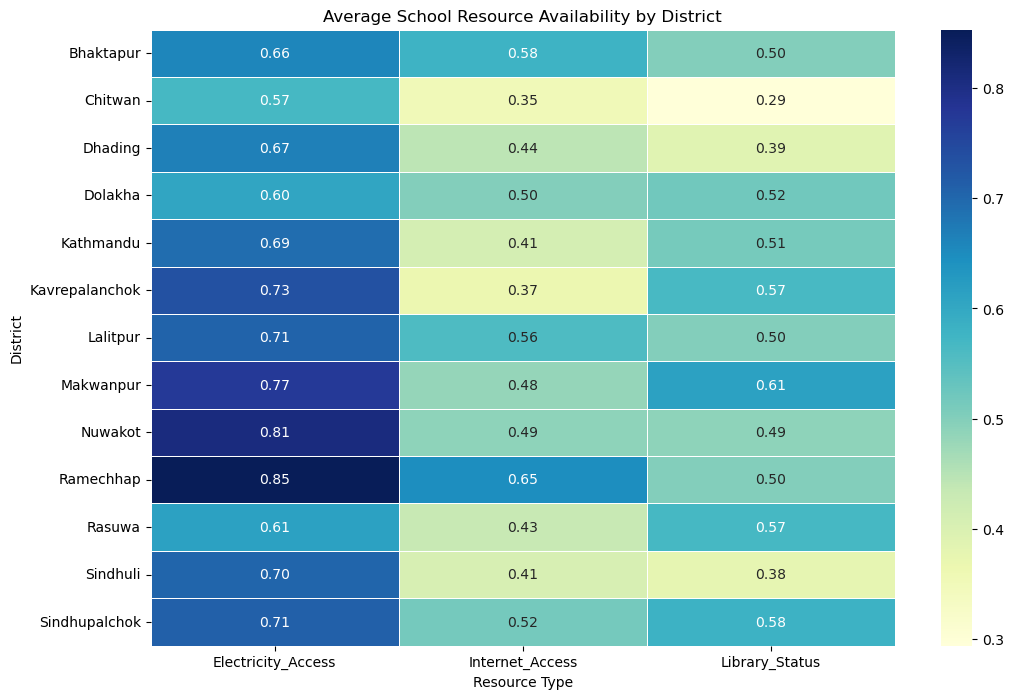

In [16]:
# heatmap that shows the distribution of different resources across multiple schools across districts.

# Selecting resource columns and district
resource_cols = ['District', 'Electricity_Access', 'Internet_Access', 'Library_Status']
school_resources = schools[resource_cols].copy()


for col in ['Electricity_Access', 'Internet_Access', 'Library_Status']:
    if school_resources[col].dtype == 'object':
        school_resources[col] = school_resources[col].map({'Y': 1, 'N': 0})

# grouping and taking the mean
resource_counts = school_resources.groupby('District')[['Electricity_Access', 'Internet_Access', 'Library_Status']].mean()


# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resource_counts, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Average School Resource Availability by District')
plt.xlabel('Resource Type')
plt.ylabel('District')
plt.show()

## **Teacher_Deployment**

In [18]:
teachers.head()

,Teacher_ID,School_ID,Subject,Training_Level,Years_of_Experience,Student_Teacher_Ratio
0,TCH0001,SCH266,Social Studies,Advanced,1,23.6
1,TCH0002,SCH272,Nepali,Advanced,5,12.6
2,TCH0003,SCH144,English,Advanced,17,11.3
3,TCH0004,SCH050,Science,Advanced,12,30.2
4,TCH0005,SCH094,Social Studies,Basic,13,21.2


In [19]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Teacher_ID             5000 non-null   object 
 1   School_ID              5000 non-null   object 
 2   Subject                5000 non-null   object 
 3   Training_Level         5000 non-null   object 
 4   Years_of_Experience    5000 non-null   int64  
 5   Student_Teacher_Ratio  5000 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 234.5+ KB


In [20]:
teachers.describe()

,Years_of_Experience,Student_Teacher_Ratio
count,5000.000000,5000.000000
mean,11.040800,20.040980
std,7.080591,7.583002
min,1.000000,2.700000
25%,6.000000,11.300000
50%,10.000000,23.000000
75%,14.000000,26.000000
max,30.000000,36.100000


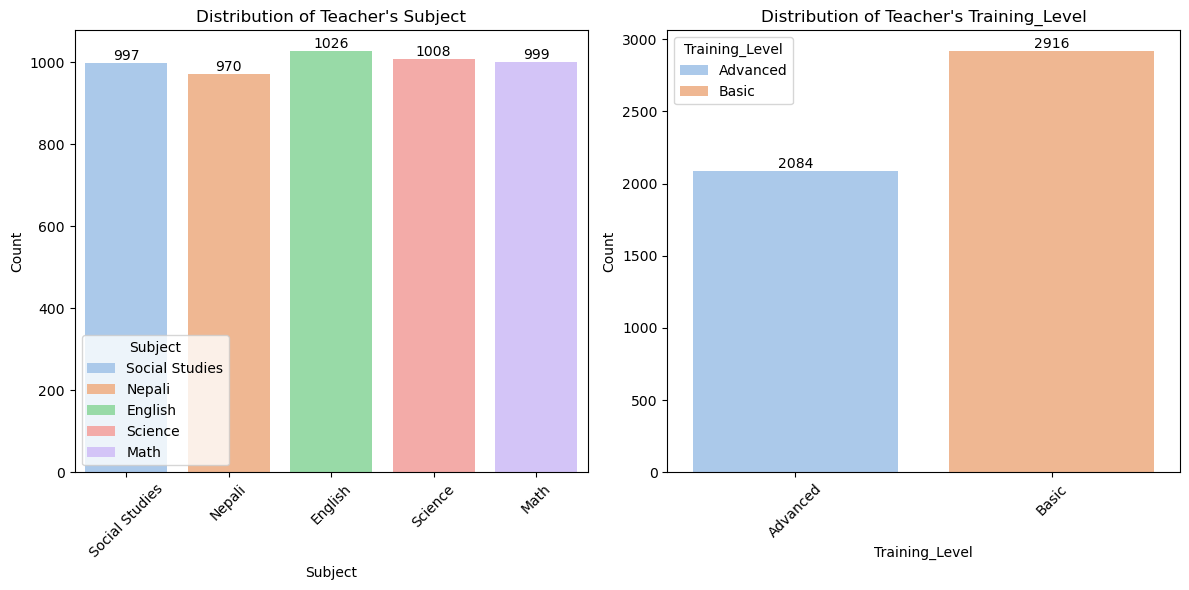

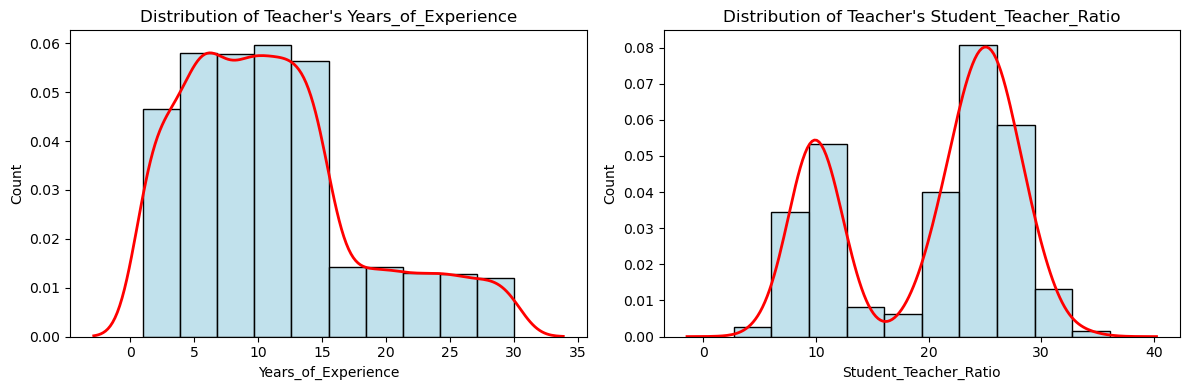

In [21]:
# bar chart for visualizing school info

# Specify the categorical columns
categorical_columns_to_plot = [
    'Subject',
    'Training_Level'
]

# plot the bar charts for school info's categorical columns
plot_categorical_bar_charts(teachers, 'Teacher', categorical_columns_to_plot)


# Histogram for visualizing continous values of school info

selected_cols= ['Years_of_Experience', 'Student_Teacher_Ratio']
plot_histograms_with_kde(teachers, 'Teacher', selected_cols, n_bins = 10)


## **Distrtict_Level_Stats**

In [23]:
districts.head()

,District,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km
0,Kathmandu,91.30,14.29,3.86
1,Lalitpur,94.87,13.76,1.69
2,Bhaktapur,89.94,11.58,1.87
3,Makwanpur,71.11,33.47,7.25
4,Dhading,71.17,38.69,8.71


In [24]:
districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   District                13 non-null     object 
 1   Literacy_Rate           13 non-null     float64
 2   Poverty_Rate            13 non-null     float64
 3   Avg_School_Distance_km  13 non-null     float64
dtypes: float64(3), object(1)
memory usage: 548.0+ bytes


In [25]:
districts.describe()

,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km
count,13.000000,13.000000,13.000000
mean,82.313077,25.542308,6.090000
std,8.127528,9.486209,2.922354
min,71.110000,11.580000,1.690000
25%,76.150000,14.290000,3.860000
50%,81.030000,28.440000,6.650000
75%,89.940000,32.350000,8.710000
max,94.870000,38.690000,9.920000


Districts in Bagmati Province:  ['Kathmandu' 'Lalitpur' 'Bhaktapur' 'Makwanpur' 'Dhading' 'Nuwakot'
 'Kavrepalchok' 'Sindhupalchok' 'Ramechhap' 'Dolakha' 'Rasuwa' 'Chitwan'
 'Bara']


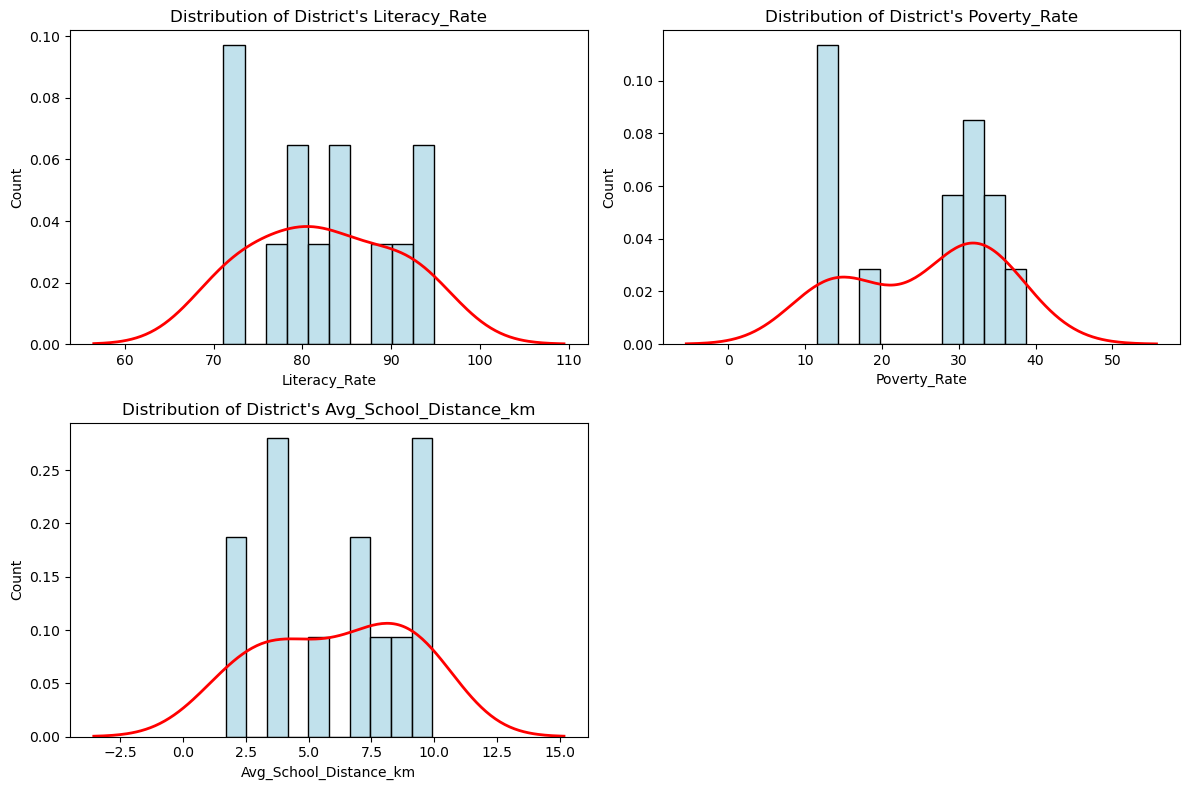

In [26]:
print("Districts in Bagmati Province: ", districts['District'].unique())


# Histogram for visualizing continous values of District level stats

selected_cols= ['Literacy_Rate', 'Poverty_Rate', 'Avg_School_Distance_km']
plot_histograms_with_kde(districts, 'District', selected_cols, n_bins = 10)


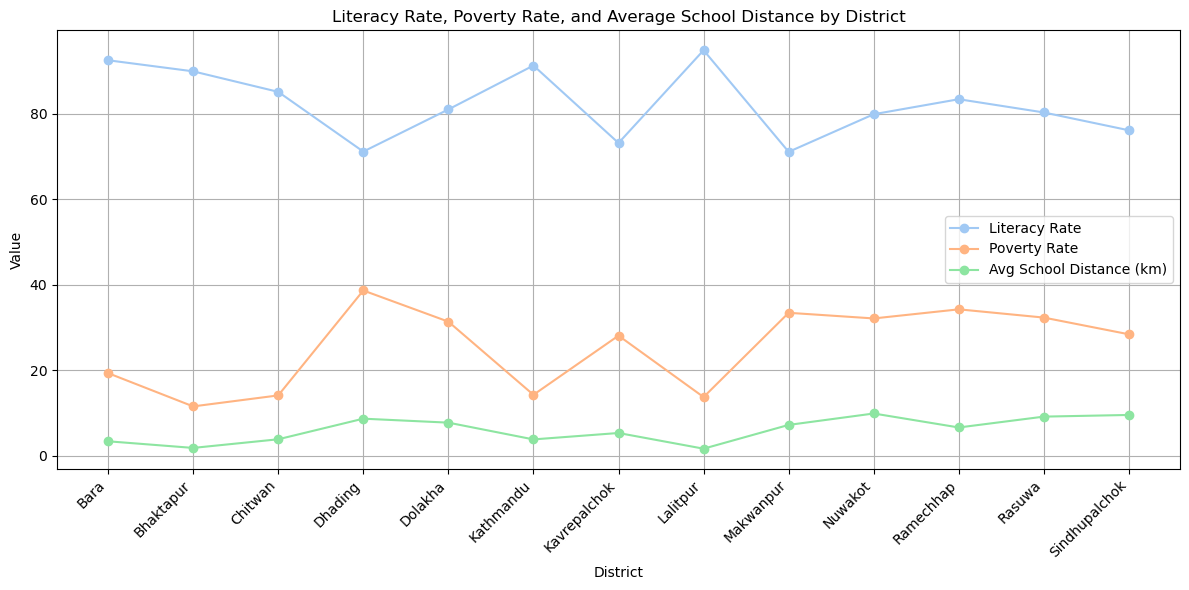

In [27]:
# ploting Literacy_Rate, Poverty_Rate and Avg_School_Distance_km vs District in line chart

# Sort the data by 'District' for a cleaner line plot
districts_sorted = districts.sort_values('District')

plt.figure(figsize=(12, 6))
plt.plot(districts_sorted['District'], districts_sorted['Literacy_Rate'], marker='o', linestyle='-', label='Literacy Rate')
plt.plot(districts_sorted['District'], districts_sorted['Poverty_Rate'], marker='o', linestyle='-', label='Poverty Rate')
plt.plot(districts_sorted['District'], districts_sorted['Avg_School_Distance_km'], marker='o', linestyle='-', label='Avg School Distance (km)')

plt.title('Literacy Rate, Poverty Rate, and Average School Distance by District')
plt.xlabel('District')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Student_Records**

In [29]:
students.head()

,Student_ID,School_ID,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status
0,STU00001,SCH298,9,Female,Low,65.6,2.52,Y
1,STU00002,SCH183,6,Female,Low,84.6,2.57,Y
2,STU00003,SCH265,12,Female,Medium,59.9,2.15,Y
3,STU00004,SCH437,6,Male,Medium,87.4,2.05,N
4,STU00005,SCH107,1,Male,Medium,89.1,2.53,N


In [30]:
print(students.info())
print("\n",students.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            50000 non-null  object 
 1   School_ID             50000 non-null  object 
 2   Grade                 50000 non-null  int64  
 3   Gender                50000 non-null  object 
 4   Socioeconomic_Status  50000 non-null  object 
 5   Attendance_Rate       50000 non-null  float64
 6   Previous_Year_GPA     50000 non-null  float64
 7   Dropout_Status        50000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.1+ MB
None

               Grade  Attendance_Rate  Previous_Year_GPA
count  50000.000000      50000.00000       50000.000000
mean       4.909940         75.01541           2.494737
std        3.396395         14.04074           0.691827
min        1.000000         50.00000           0.000000
25%        2.000000         63.20

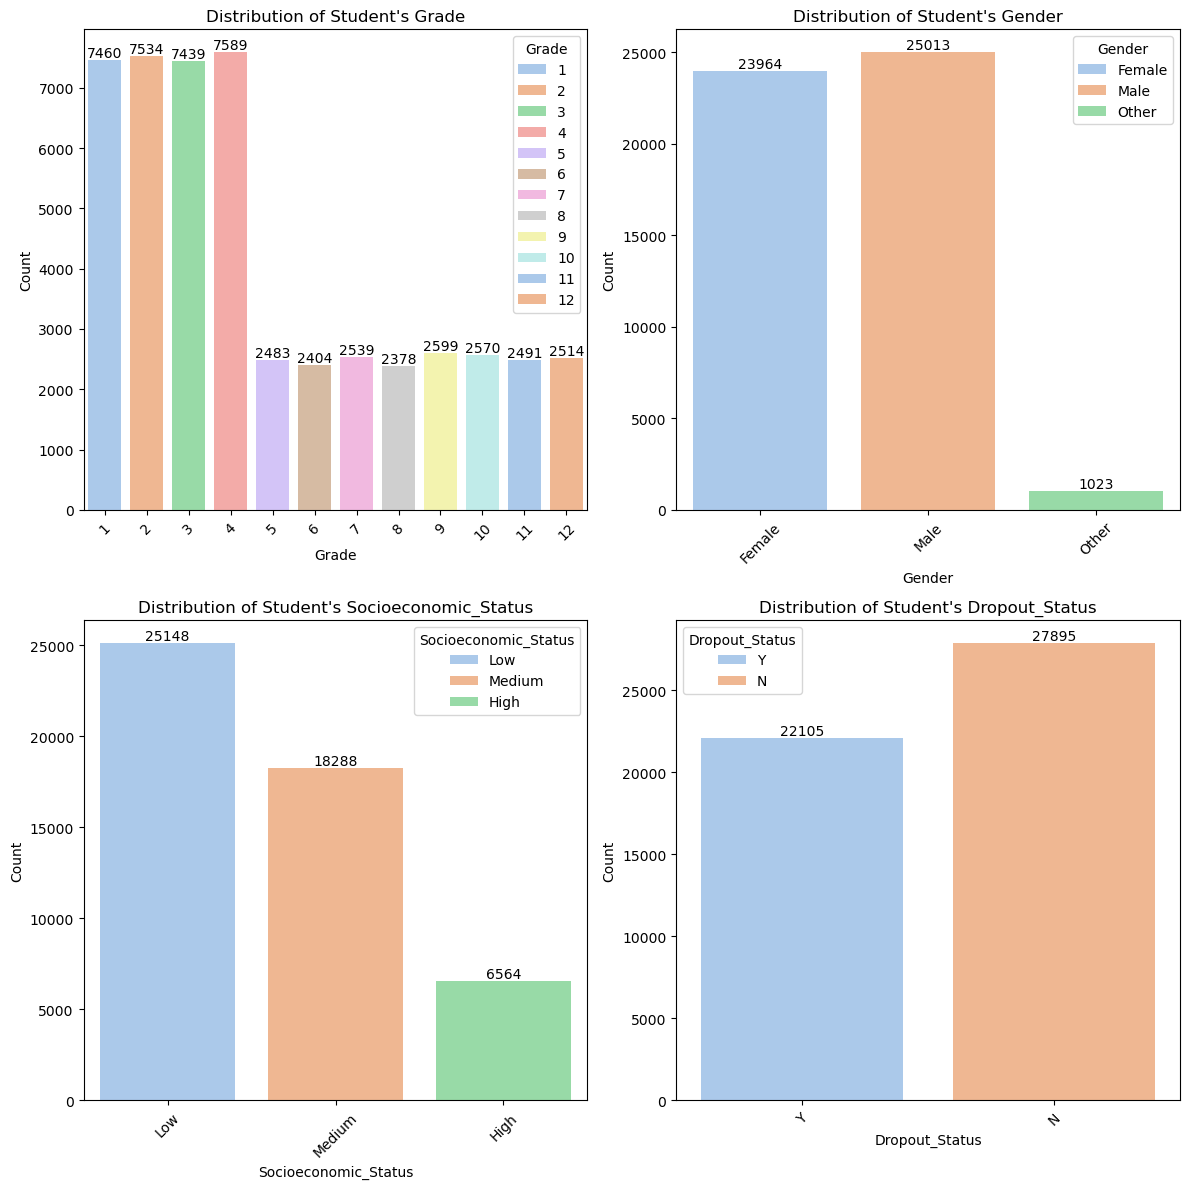

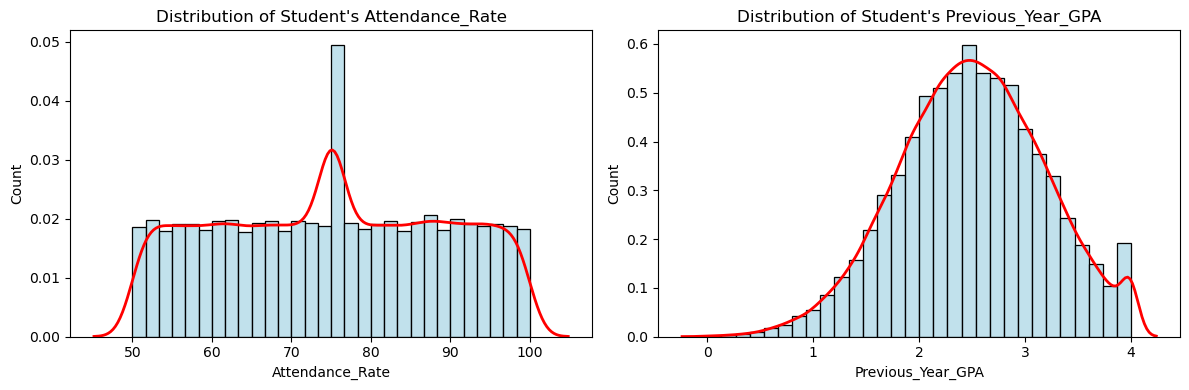

In [31]:
# bar chart for visualizing school info

# Specify the categorical columns
categorical_columns_to_plot = [
    'Grade',
    'Gender',
    'Socioeconomic_Status',
    'Dropout_Status'
]

# plot the bar charts for school info's categorical columns
plot_categorical_bar_charts(students, 'Student', categorical_columns_to_plot)



# Histogram for visualizing continous values of school info

selected_cols= ['Attendance_Rate', 'Previous_Year_GPA']
plot_histograms_with_kde(students, 'Student', selected_cols, n_bins = 30)

# **2. Merging Datasets for Modeling**

In [33]:
# Step 1: Merge Students with Schools
merged_data = students.merge(
    schools,
    on='School_ID',
    how='left'
)

# Step 2: Merge with Districts
merged_data = merged_data.merge(
    districts,
    on='District',
    how='left'
)

# Step 3: Aggregate teacher data by school and merge
# Calculate average teacher metrics per school
teacher_agg = teachers.groupby('School_ID').agg({
    'Training_Level': lambda x: (x == 'Advanced').mean(),  # % of advanced teachers
    'Years_of_Experience': 'mean',
    'Student_Teacher_Ratio': 'mean'
}).reset_index()

teacher_agg = teacher_agg.rename(columns={
    'Training_Level': 'Pct_Advanced_Teachers',
    'Years_of_Experience': 'Avg_Teacher_Experience',
    'Student_Teacher_Ratio': 'Avg_Student_Teacher_Ratio'
})

# Merge with the main dataset
merged_data = merged_data.merge(
    teacher_agg,
    on='School_ID',
    how='left'
)

# Step 4: Save the final merged dataset
# merged_data.to_csv('final_merged_student_data.csv', index=False)

print(f"Merged dataset shape: {merged_data.shape}")

Merged dataset shape: (50000, 20)


In [34]:
df = merged_data
df.head()

,Student_ID,School_ID,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km,Pct_Advanced_Teachers,Avg_Teacher_Experience,Avg_Student_Teacher_Ratio
0,STU00001,SCH298,9,Female,Low,65.6,2.52,Y,Lalitpur,Rural,1.0,Y,N,N,94.87,13.76,1.69,0.375,6.375,25.650000
1,STU00002,SCH183,6,Female,Low,84.6,2.57,Y,Lalitpur,Rural,2.4,Y,N,N,94.87,13.76,1.69,0.000,7.000,25.708333
2,STU00003,SCH265,12,Female,Medium,59.9,2.15,Y,Bhaktapur,Urban,3.5,N,Y,Y,89.94,11.58,1.87,0.500,20.100,9.020000
3,STU00004,SCH437,6,Male,Medium,87.4,2.05,N,Sindhuli,Rural,2.0,N,N,Y,NaN,NaN,NaN,0.200,9.200,24.550000
4,STU00005,SCH107,1,Male,Medium,89.1,2.53,N,Rasuwa,Urban,2.1,Y,N,Y,80.32,32.35,9.19,0.625,19.625,10.412500


In [35]:
# dropping unnecessary cols
df = df.drop(columns=['Student_ID', 'School_ID'])

In [36]:
# handling missing values if any
df['Literacy_Rate'] = df['Literacy_Rate'].fillna(df['Literacy_Rate'].median())

df['Poverty_Rate'] = df['Poverty_Rate'].fillna(df['Poverty_Rate'].median())

df['Avg_School_Distance_km'] = df['Avg_School_Distance_km'].fillna(df['Avg_School_Distance_km'].median())


In [37]:
df.describe(include='all')

,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km,Pct_Advanced_Teachers,Avg_Teacher_Experience,Avg_Student_Teacher_Ratio
count,50000.000000,50000,50000,50000.00000,50000.000000,50000,50000,50000,50000.000000,50000,50000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
unique,NaN,3,3,NaN,NaN,2,13,2,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,Low,NaN,NaN,N,Chitwan,Rural,NaN,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,25013,25148,NaN,NaN,27895,5046,33747,NaN,34625,26524,25847,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.909940,NaN,NaN,75.01541,2.494737,NaN,NaN,NaN,2.486512,NaN,NaN,NaN,82.243141,26.393905,6.523330,0.412251,10.993061,20.121454
std,3.396395,NaN,NaN,14.04074,0.691827,NaN,NaN,NaN,1.007281,NaN,NaN,NaN,6.551067,9.214559,2.715144,0.205987,4.809731,7.100208
min,1.000000,NaN,NaN,50.00000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,71.110000,11.580000,1.690000,0.000000,4.300000,8.144444
25%,2.000000,NaN,NaN,63.20000,2.020000,NaN,NaN,NaN,1.700000,NaN,NaN,NaN,79.910000,14.290000,3.890000,0.250000,7.428571,10.412500
50%,4.000000,NaN,NaN,75.10000,2.500000,NaN,NaN,NaN,2.300000,NaN,NaN,NaN,81.030000,31.400000,7.250000,0.400000,8.777778,24.416667
75%,8.000000,NaN,NaN,86.90000,2.970000,NaN,NaN,NaN,3.100000,NaN,NaN,NaN,85.140000,32.350000,8.710000,0.555556,15.857143,25.300000


# **3. Understanding the Merged Dataset**

In [39]:
df.info() # missing values has already been handled while merging the datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Grade                      50000 non-null  int64  
 1   Gender                     50000 non-null  object 
 2   Socioeconomic_Status       50000 non-null  object 
 3   Attendance_Rate            50000 non-null  float64
 4   Previous_Year_GPA          50000 non-null  float64
 5   Dropout_Status             50000 non-null  object 
 6   District                   50000 non-null  object 
 7   Location_Type              50000 non-null  object 
 8   Infrastructure_Score       50000 non-null  float64
 9   Electricity_Access         50000 non-null  object 
 10  Internet_Access            50000 non-null  object 
 11  Library_Status             50000 non-null  object 
 12  Literacy_Rate              50000 non-null  float64
 13  Poverty_Rate               50000 non-null  flo

## **EDA of Merged Dataset**

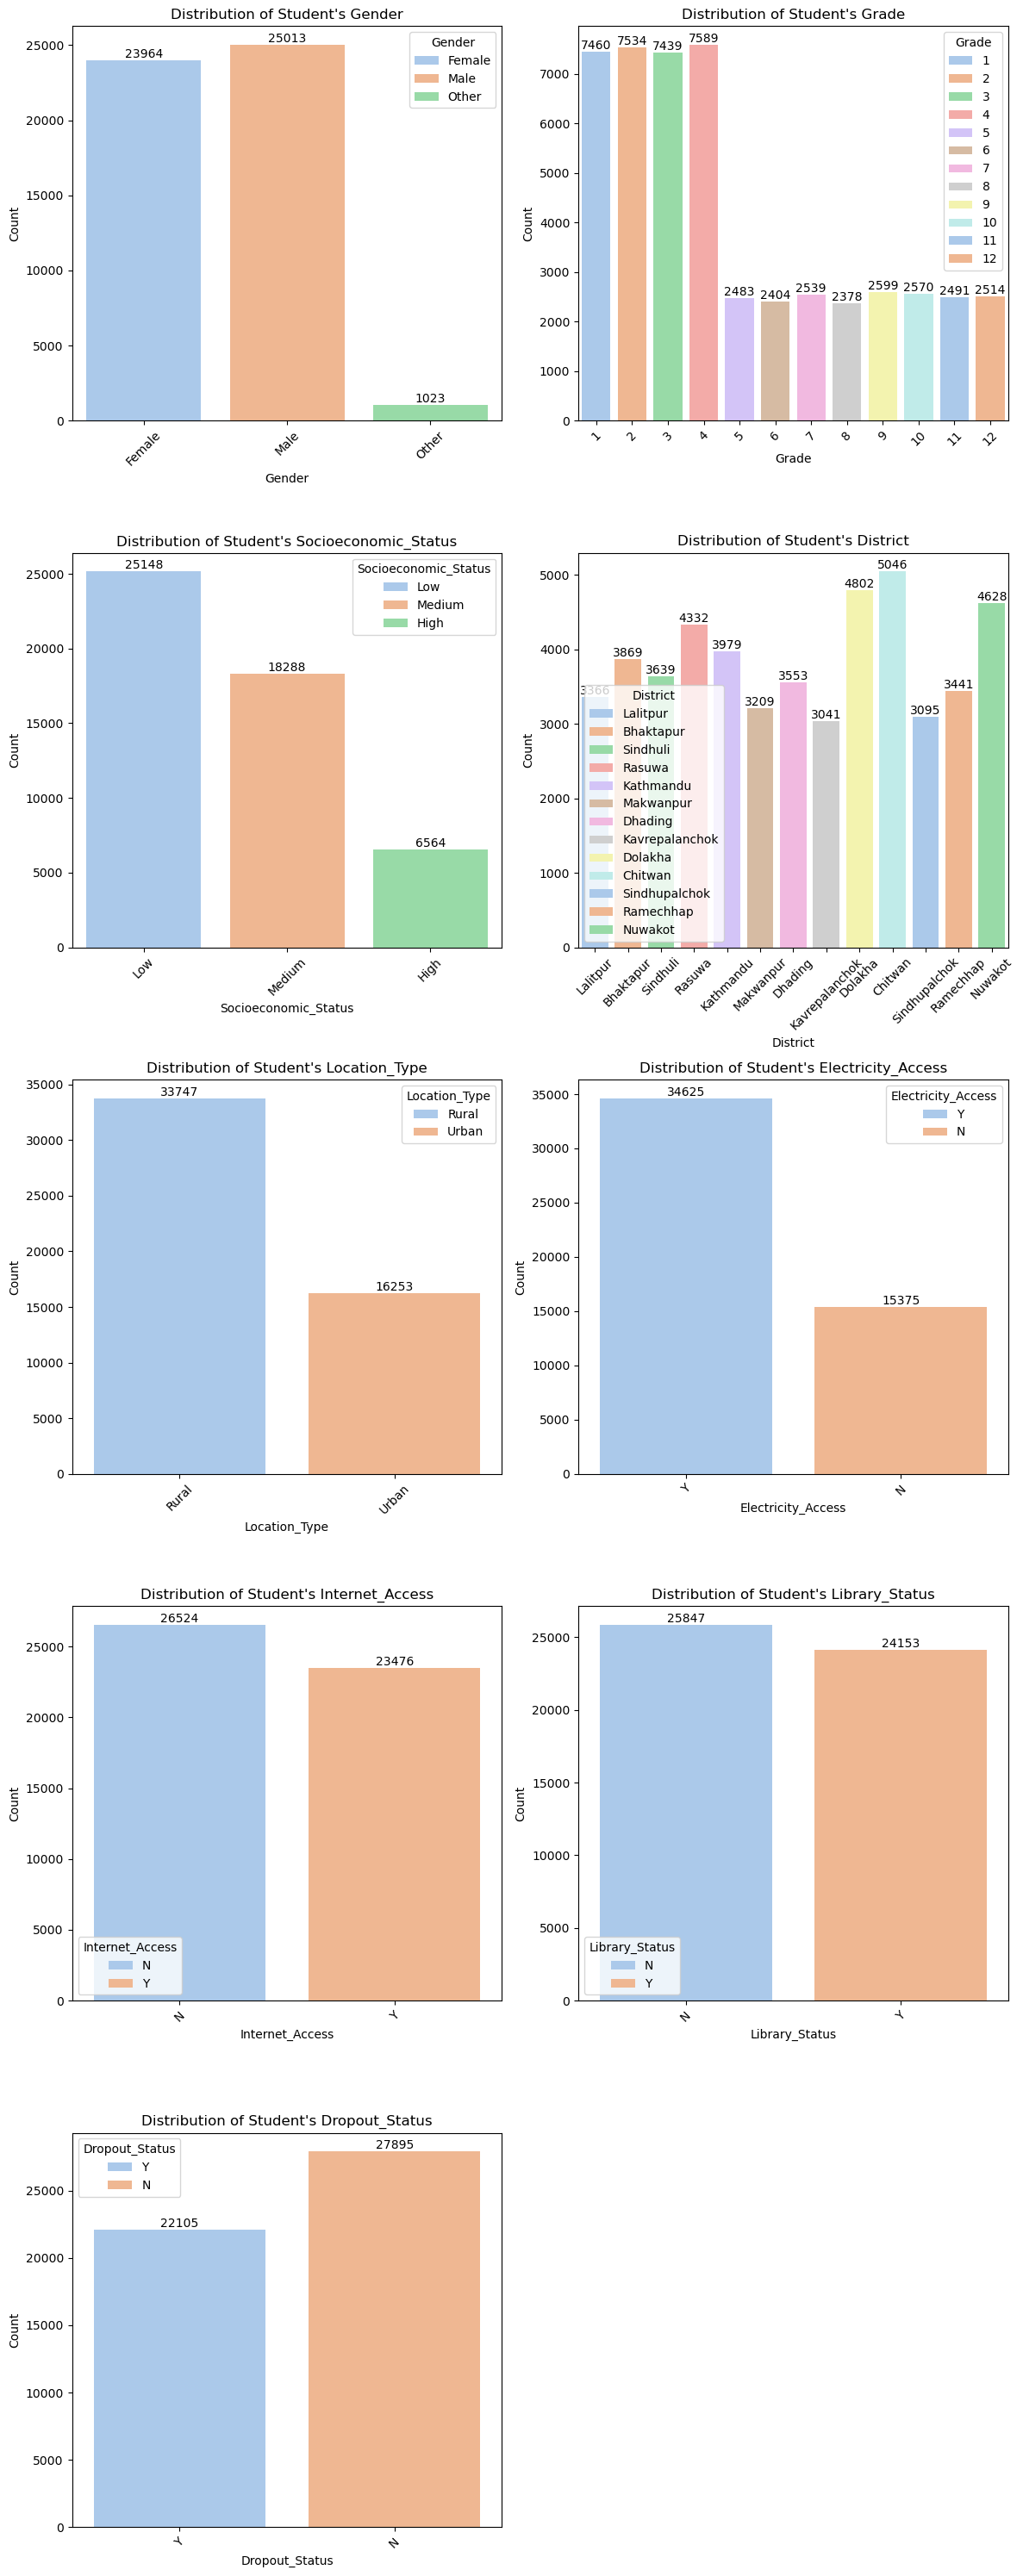

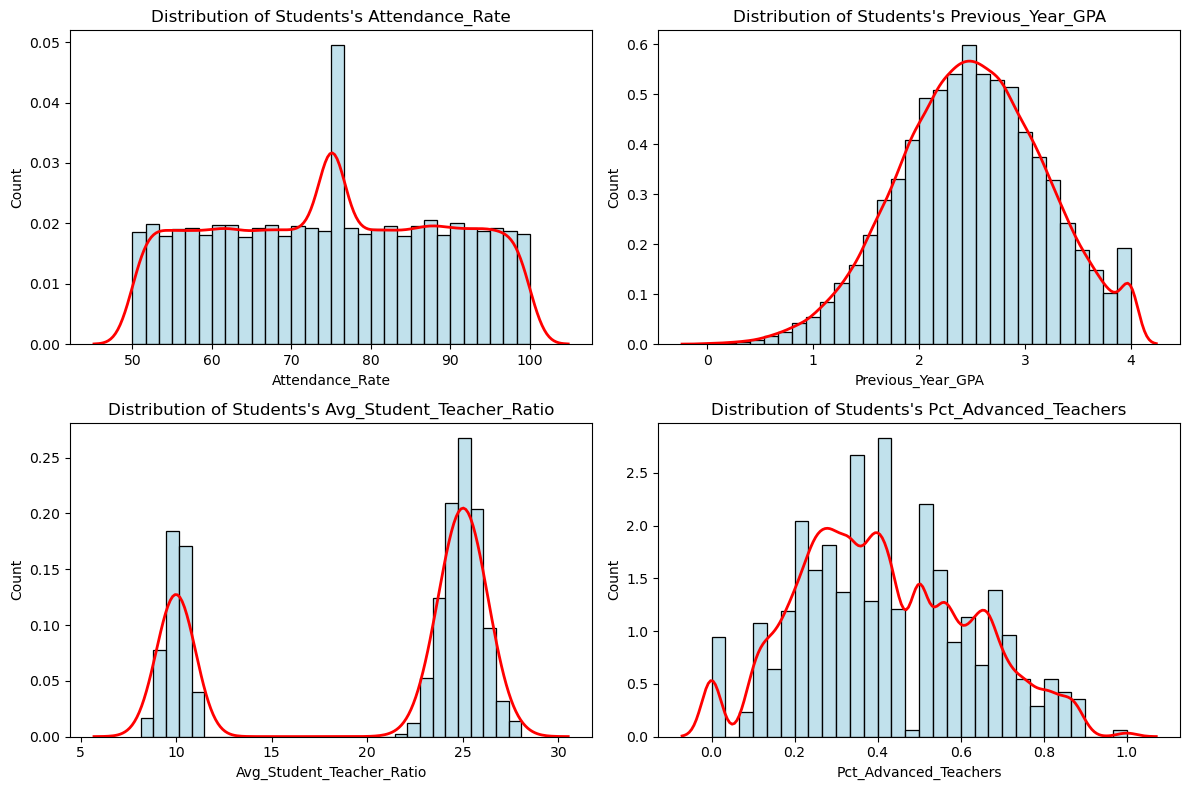

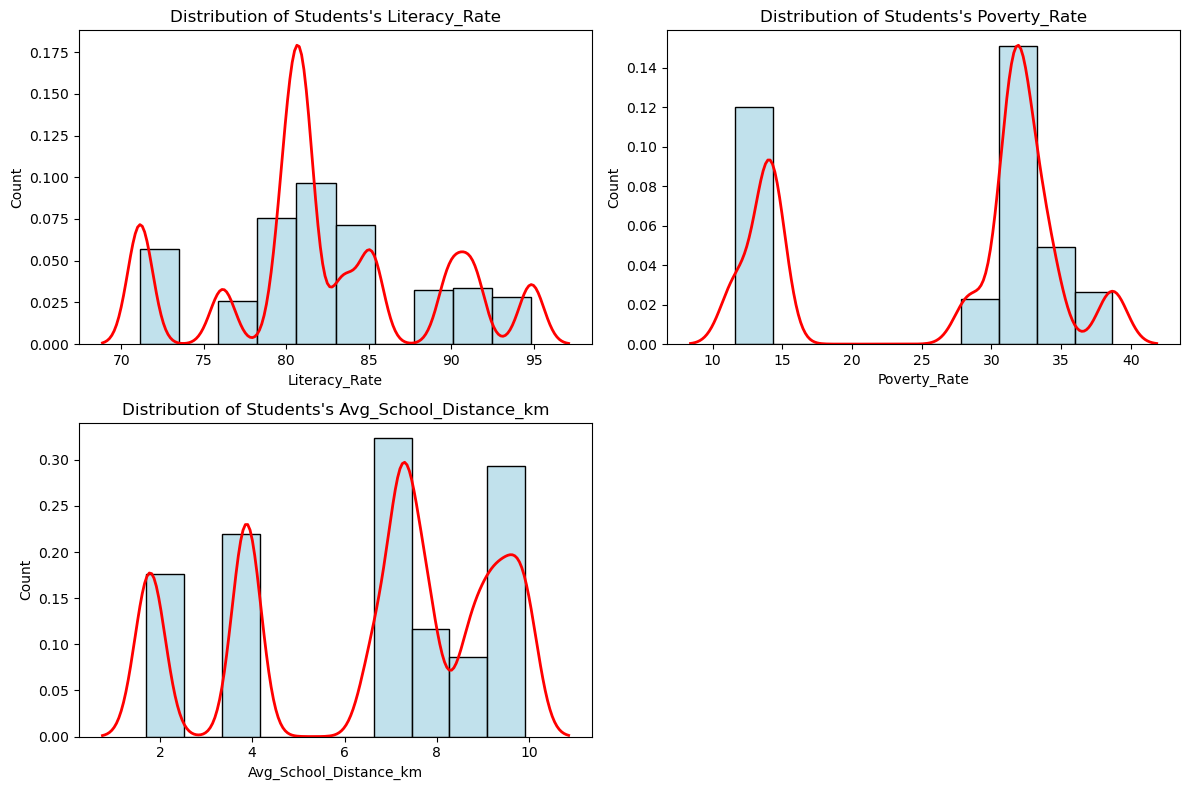

In [41]:
# bar chart for visualizing student data

# Specify the categorical columns
categorical_columns_to_plot = [
    'Gender',
    'Grade',
    'Socioeconomic_Status',
    'District',
    'Location_Type',
    'Electricity_Access',
    'Internet_Access',
    'Library_Status',
    'Dropout_Status' # Include the target variable as it's categorical
]

# plot the bar charts for categorical columns
plot_categorical_bar_charts(df, 'Student', categorical_columns_to_plot)


# plotting histograms

selected_cols = ['Attendance_Rate', 'Previous_Year_GPA', 'Avg_Student_Teacher_Ratio','Pct_Advanced_Teachers']
plot_histograms_with_kde(df, 'Students', selected_cols, n_bins = 30)

selected_cols2= ['Literacy_Rate', 'Poverty_Rate', 'Avg_School_Distance_km']
plot_histograms_with_kde(df, 'Students', selected_cols2, n_bins = 10)

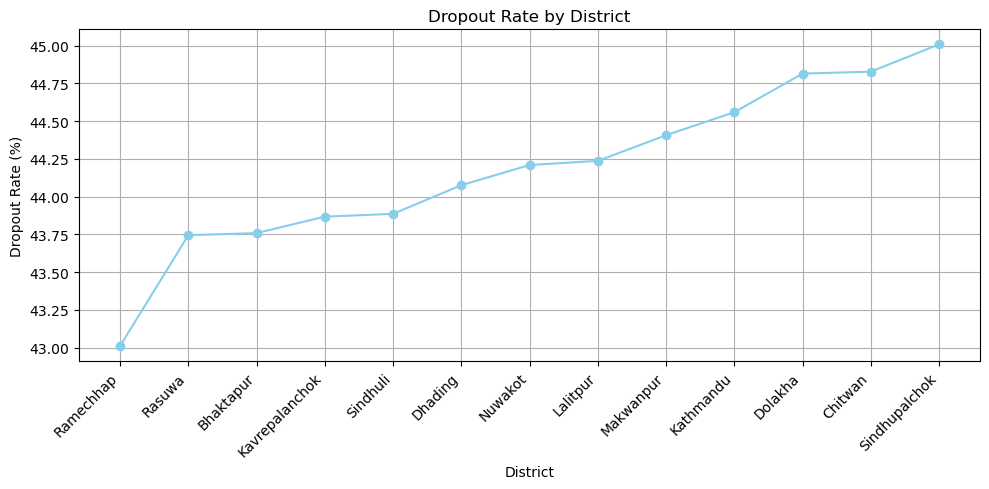

In [42]:
# line chart of Dropout vs district

# Calculate the raw dropout rate per district
dropout_rate_by_district = df.groupby('District')['Dropout_Status'].value_counts(normalize=True).unstack()['Y'].fillna(0)

# Sort the data by dropout rate for better visualization
dropout_rate_by_district_sorted = dropout_rate_by_district.sort_values()

plt.figure(figsize=(10, 5))
plt.plot(dropout_rate_by_district_sorted.index, dropout_rate_by_district_sorted.values * 100, marker='o', linestyle='-', color='skyblue')

plt.title('Dropout Rate by District')
plt.xlabel('District')
plt.ylabel('Dropout Rate (%)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

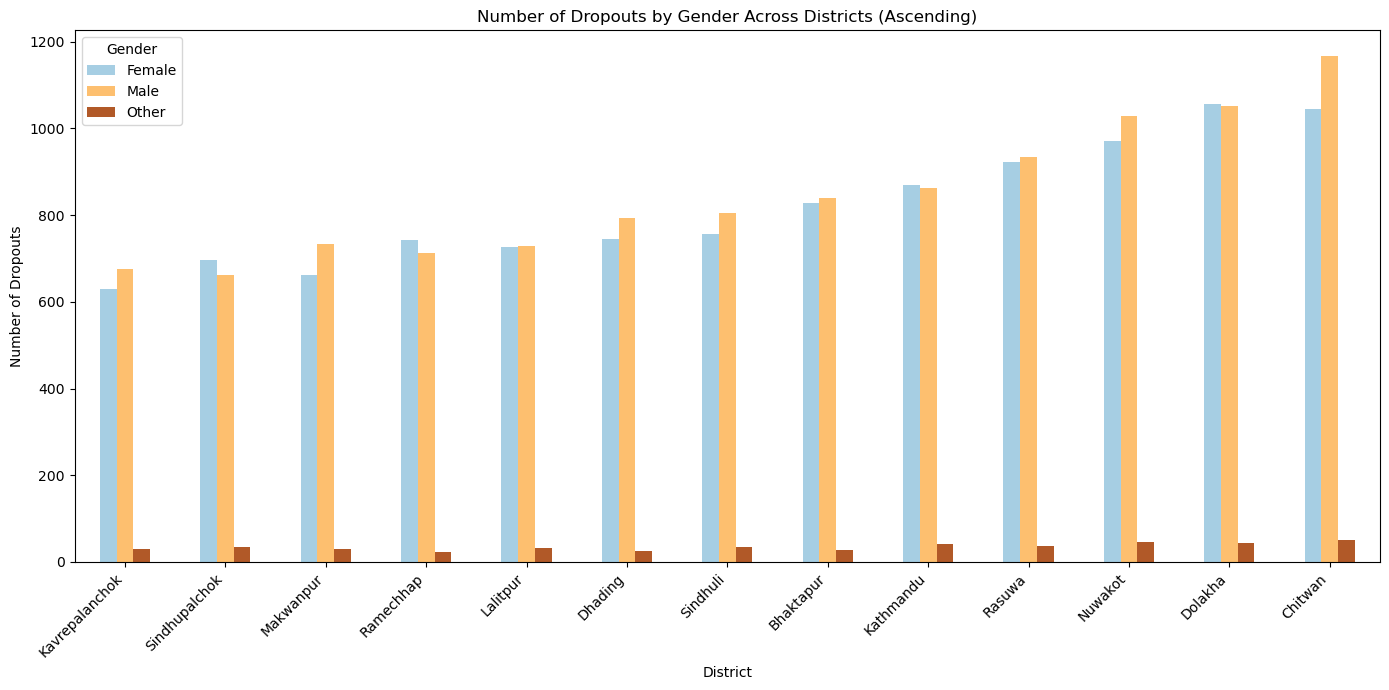

In [43]:
# Filter and group dropout data
dropout_by_district_gender = (
    df[df['Dropout_Status'] == 'Y']
    .groupby(['District', 'Gender'])
    .size()
    .unstack(fill_value=0)
)

# Add a "Total" column for sorting
dropout_by_district_gender['Total'] = dropout_by_district_gender.sum(axis=1)

# Sort by total dropouts in ascending order
dropout_by_district_gender = dropout_by_district_gender.sort_values('Total')

# Drop the "Total" column before plotting
dropout_by_district_gender = dropout_by_district_gender.drop(columns='Total')

# Plot
plt.figure(figsize=(14, 7))
dropout_by_district_gender.plot(kind='bar', stacked=False, figsize=(14, 7), colormap='Paired')

plt.title('Number of Dropouts by Gender Across Districts (Ascending)')
plt.xlabel('District')
plt.ylabel('Number of Dropouts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()



Number of Dropouts by Gender:
Gender
Male      10997
Female    10651
Other       457
Name: count, dtype: int64


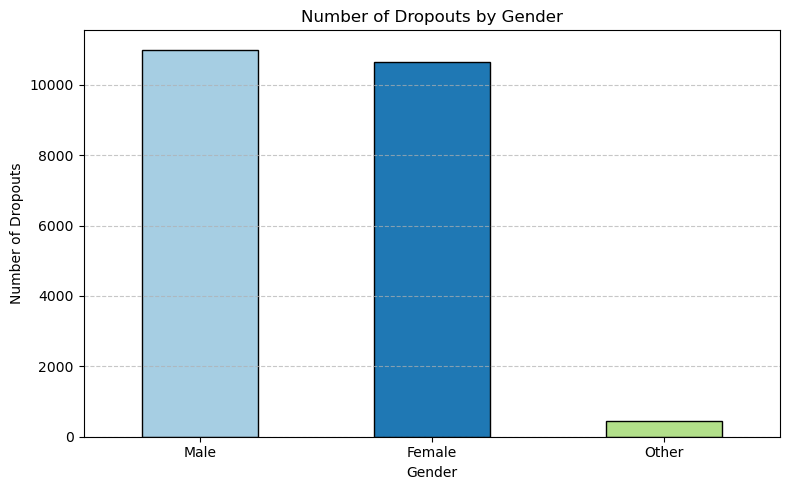

In [44]:
# Print the total number of dropouts by gender
dropout_counts_by_gender = df[df['Dropout_Status'] == 'Y']['Gender'].value_counts()
print("\nNumber of Dropouts by Gender:")
print(dropout_counts_by_gender)


# Plotting bar graph
plt.figure(figsize=(8, 5))
colors = sns.color_palette("Paired")
dropout_counts_by_gender.plot(kind='bar', color=colors, edgecolor='black')

# Labels and title
plt.title('Number of Dropouts by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dropouts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# **4. Outliers Detection and Removal**

In [46]:
# function to make subplots of box plots

def plot_boxplots(df, status, columns):
    """
    Plots subplots of boxplots

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): A list of numerical column names to create box plots for.
    """
    n_cols = 4  # More columns per row for smaller plots
    n_rows = (len(columns) + n_cols - 1) // n_cols  # Dynamically calculate number of rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2.5)) # Reduced figure size
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # Use a colorful palette
    palette = sns.color_palette('tab10', len(columns))

    for i, col in enumerate(columns):
        if col in df.columns and np.issubdtype(df[col].dtype, np.number):
            # Use the palette to assign a color to each boxplot
            sns.boxplot(data=df, y=col, ax=axes[i], color=palette[i % len(palette)])
            axes[i].set_title(f'{col}', fontsize=10) # Smaller title font size
            axes[i].set_ylabel('') # Remove y-axis label to save space
            axes[i].tick_params(axis='y', labelsize=8) # Smaller tick labels
            axes[i].set_xlabel('') # Remove x-axis label

        else:
            print(f"Warning: Column '{col}' not found or is not numerical in the DataFrame.")
            # Hide the unused subplot if the column is not found or not numerical
            axes[i].axis('off')

    # Hide any remaining unused subplots
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

    fig.suptitle(status, fontsize=14)
    plt.tight_layout()
    plt.show()


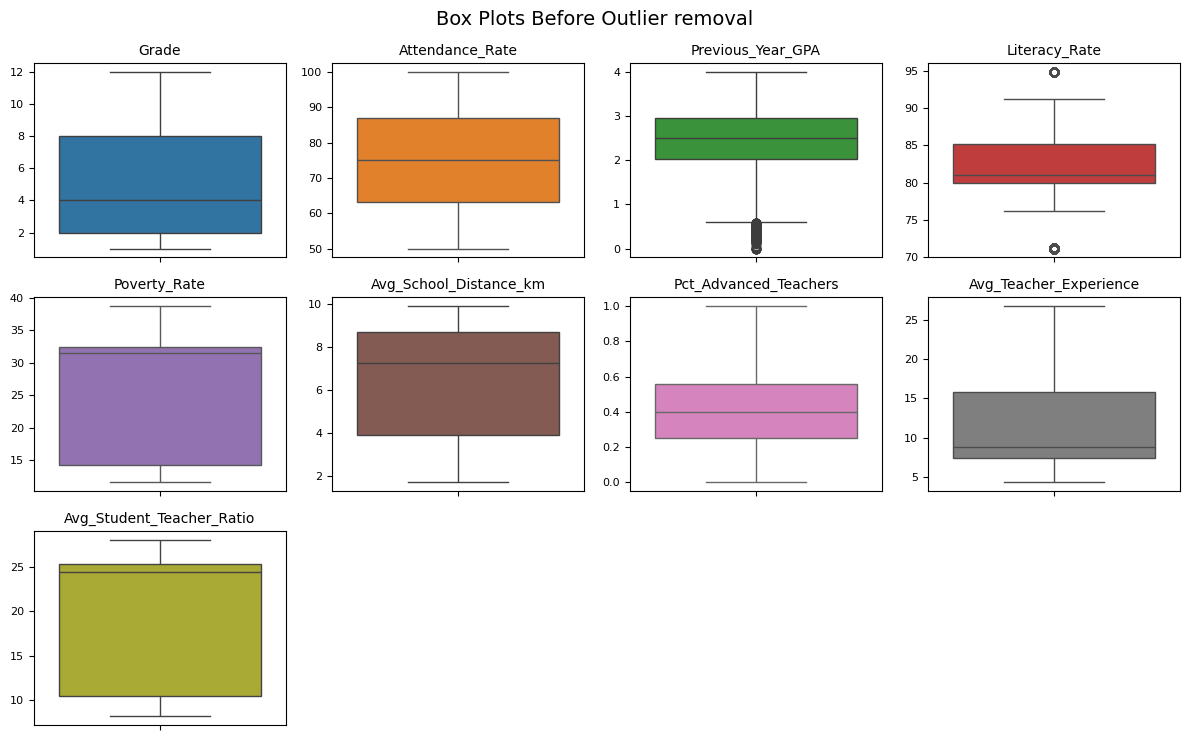

In [47]:
cols_to_plot = [
    'Grade',
    'Attendance_Rate',
    'Previous_Year_GPA',
    'Literacy_Rate',
    'Poverty_Rate',
    'Avg_School_Distance_km',
    'Pct_Advanced_Teachers',
    'Avg_Teacher_Experience',
    'Avg_Student_Teacher_Ratio'
]

# plotting boxplots
plot_boxplots(df, 'Box Plots Before Outlier removal', cols_to_plot)

In [48]:
# function to calculate number of outliers in each numerical col using IQR

def detect_and_count_outliers_iqr(df, column):
    """
    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the numerical column to check for outliers.
    Returns:The number of outliers detected in the column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

# calculating no. of outliers
numerical_cols_for_outliers = [
    'Attendance_Rate',
    'Previous_Year_GPA',
    'Literacy_Rate',
    'Poverty_Rate',
    'Avg_School_Distance_km',
    'Pct_Advanced_Teachers',
    'Avg_Teacher_Experience',
    'Avg_Student_Teacher_Ratio'
]

print("Number of outliers using IQR method:")
for col in numerical_cols_for_outliers:
    if col in df.columns and np.issubdtype(df[col].dtype, np.number):
        num_outliers = detect_and_count_outliers_iqr(df, col)
        print(f"- {col}: {num_outliers}")
    else:
        print(f"- Warning: Column '{col}' not found or is not numerical.")


Number of outliers using IQR method:
- Attendance_Rate: 0
- Previous_Year_GPA: 173
- Literacy_Rate: 10128
- Poverty_Rate: 0
- Avg_School_Distance_km: 0
- Pct_Advanced_Teachers: 0
- Avg_Teacher_Experience: 0
- Avg_Student_Teacher_Ratio: 0


In [49]:
# function to remove outliers using IQR method

def remove_outliers_iqr(df, column):
    """
    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the numerical column to remove outliers from.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed for the specified column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_cleaned



# Apply outlier removal for selected columns
cols_to_remove_outliers = [
    'Attendance_Rate',
    'Previous_Year_GPA',
    'Literacy_Rate',
    'Poverty_Rate',
    'Avg_School_Distance_km',
    'Pct_Advanced_Teachers',
    'Avg_Teacher_Experience',
    'Avg_Student_Teacher_Ratio'
]

# Create a copy to avoid modifying the original DataFrame directly in the loop
df_cleaned = df.copy()

print("\nDataFrame shape before outlier removal:", df_cleaned.shape)
print()

for col in cols_to_remove_outliers:
    if col in df_cleaned.columns and np.issubdtype(df_cleaned[col].dtype, np.number):
        original_shape = df_cleaned.shape[0]
        df_cleaned = remove_outliers_iqr(df_cleaned, col)
        rows_removed = original_shape - df_cleaned.shape[0]
        print(f"Removed {rows_removed} outliers from column '{col}'.")
    else:
        print(f"Warning: Column '{col}' not found or is not numerical. Skipping outlier removal for this column.")

print("\nDataFrame shape after outlier removal:", df_cleaned.shape)

# Display some info about the cleaned DataFrame
df_cleaned.info()


DataFrame shape before outlier removal: (50000, 18)

Removed 0 outliers from column 'Attendance_Rate'.
Removed 173 outliers from column 'Previous_Year_GPA'.
Removed 10083 outliers from column 'Literacy_Rate'.
Removed 0 outliers from column 'Poverty_Rate'.
Removed 0 outliers from column 'Avg_School_Distance_km'.
Removed 0 outliers from column 'Pct_Advanced_Teachers'.
Removed 0 outliers from column 'Avg_Teacher_Experience'.
Removed 0 outliers from column 'Avg_Student_Teacher_Ratio'.

DataFrame shape after outlier removal: (39744, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 39744 entries, 2 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Grade                      39744 non-null  int64  
 1   Gender                     39744 non-null  object 
 2   Socioeconomic_Status       39744 non-null  object 
 3   Attendance_Rate            39744 non-null  float64
 4   Previous_Year_GP

In [50]:
df = df_cleaned

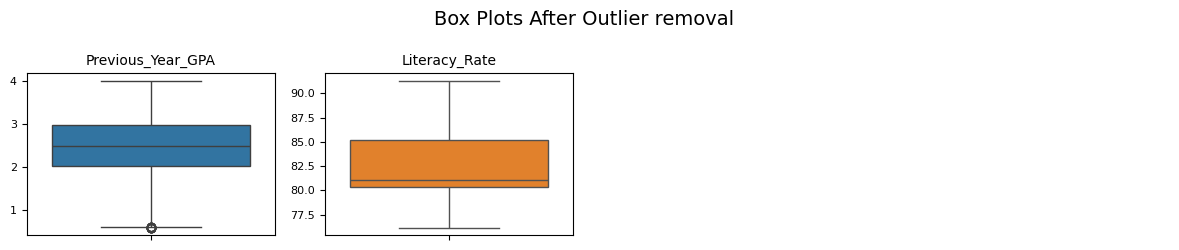

In [51]:
cols_to_plot = [
    'Previous_Year_GPA',
    'Literacy_Rate'
]
plot_boxplots(df, 'Box Plots After Outlier removal', cols_to_plot)

## **HeatMap**

In [53]:
# function to plot heatmap of the correlation matrix for numerical cols

def plot_heatmap(df, figsize=(8, 6), cmap='coolwarm'):
    """
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        figsize (tuple): Size of the heatmap figure. Default is (10, 8).
        cmap (str): Colormap to use for heatmap. Default is 'coolwarm'.
    """
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=np.number)

    # Compute correlation matrix
    correlation_matrix = numerical_cols.corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Heatmap of Numerical Features')
    plt.show()

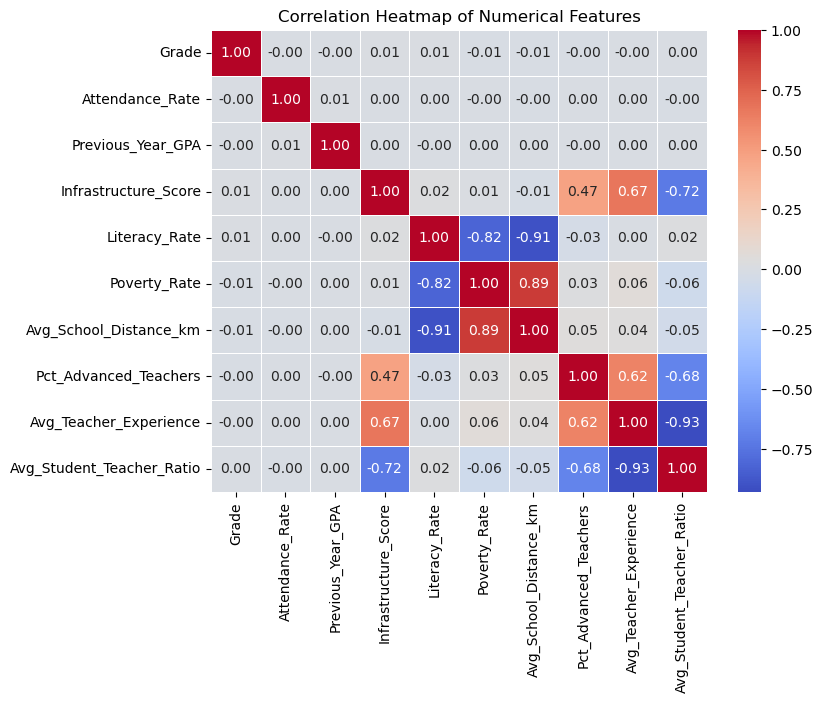

In [54]:
plot_heatmap(df)

# **6. Modeling (Logistic Regression)**

In [56]:
# resetting index
df = df.reset_index(drop=True)
df.head()

,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km,Pct_Advanced_Teachers,Avg_Teacher_Experience,Avg_Student_Teacher_Ratio
0,12,Female,Medium,59.9,2.15,Y,Bhaktapur,Urban,3.5,N,Y,Y,89.94,11.58,1.87,0.500000,20.100000,9.020000
1,6,Male,Medium,87.4,2.05,N,Sindhuli,Rural,2.0,N,N,Y,81.03,31.40,7.25,0.200000,9.200000,24.550000
2,1,Male,Medium,89.1,2.53,N,Rasuwa,Urban,2.1,Y,N,Y,80.32,32.35,9.19,0.625000,19.625000,10.412500
3,3,Female,High,74.6,2.54,N,Kathmandu,Urban,2.9,Y,Y,Y,91.30,14.29,3.86,0.555556,15.777778,9.833333
4,9,Male,Medium,86.6,2.18,N,Rasuwa,Rural,1.2,N,N,N,80.32,32.35,9.19,0.272727,9.272727,26.127273


In [57]:
print(df.shape)
df.head()

(39744, 18)


,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status,Literacy_Rate,Poverty_Rate,Avg_School_Distance_km,Pct_Advanced_Teachers,Avg_Teacher_Experience,Avg_Student_Teacher_Ratio
0,12,Female,Medium,59.9,2.15,Y,Bhaktapur,Urban,3.5,N,Y,Y,89.94,11.58,1.87,0.500000,20.100000,9.020000
1,6,Male,Medium,87.4,2.05,N,Sindhuli,Rural,2.0,N,N,Y,81.03,31.40,7.25,0.200000,9.200000,24.550000
2,1,Male,Medium,89.1,2.53,N,Rasuwa,Urban,2.1,Y,N,Y,80.32,32.35,9.19,0.625000,19.625000,10.412500
3,3,Female,High,74.6,2.54,N,Kathmandu,Urban,2.9,Y,Y,Y,91.30,14.29,3.86,0.555556,15.777778,9.833333
4,9,Male,Medium,86.6,2.18,N,Rasuwa,Rural,1.2,N,N,N,80.32,32.35,9.19,0.272727,9.272727,26.127273


## **Encoding Categorical Columns**

In [59]:
# Manual binary & ordinal mapping
binary_map = {'Y': 1, 'N': 0}
df['Library_Status'] = df['Library_Status'].map(binary_map)
df['Electricity_Access'] = df['Electricity_Access'].map(binary_map)
df['Internet_Access'] = df['Internet_Access'].map(binary_map)
df['Location_Type'] = df['Location_Type'].map({'Urban': 1, 'Rural': 0})

# Ordinal encoding
df['Socioeconomic_Status'] = df['Socioeconomic_Status'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Target variable
df['Dropout_Status'] = df['Dropout_Status'].map({'N': 0, 'Y': 1})

# One-hot encoding nominal features
df = pd.get_dummies(df, columns=['Gender', 'District'], drop_first=True)  # drop_first=True avoids dummy trap (multicollinearity)



In [60]:
# standardizing continuous numeric cols}
cont_numeric_cols = ['Attendance_Rate', 'Previous_Year_GPA']
scaler = StandardScaler()
cont_numeric_cols_scaled = scaler.fit_transform(df[cont_numeric_cols])

In [61]:
# separating features and target var
y = df['Dropout_Status']    # Target vector
X = df.drop(columns=['Dropout_Status'])  # Features

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify for better representation

Best hyperparameters found:
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Evaluation on the test set:
[[3853  583]
 [ 411 3102]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4436
           1       0.84      0.88      0.86      3513

    accuracy                           0.87      7949
   macro avg       0.87      0.88      0.87      7949
weighted avg       0.88      0.87      0.88      7949

ROC AUC Score: 0.93


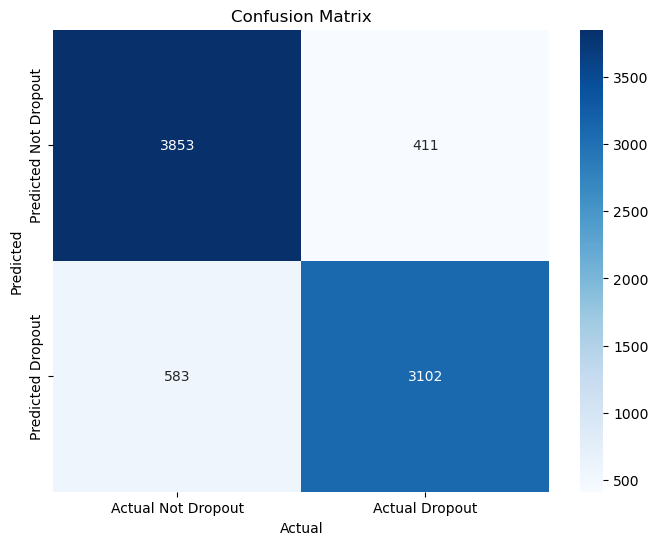

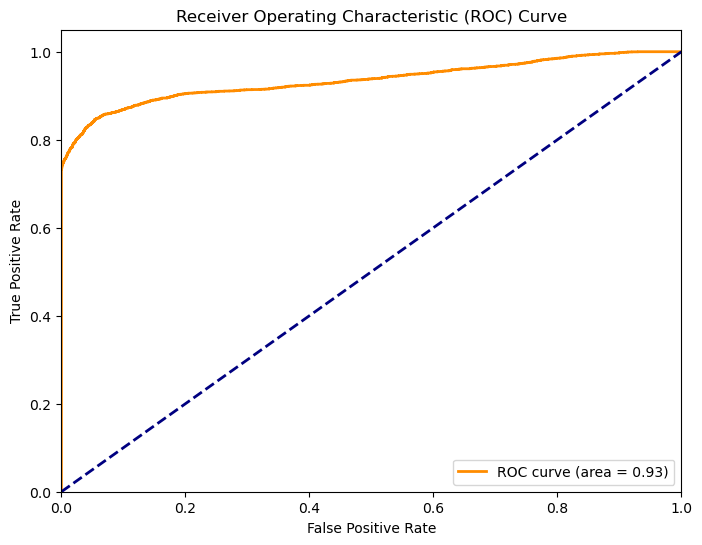

In [63]:
# Defining the Logistic regression model

# model addresses class imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Defining the parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # smaller values of C -> stronger regularization
    'penalty': ['l2'],                   # l2 regularization
    'solver': ['liblinear', 'lbfgs']     # algo for optimization
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,    # logisticReg
    param_grid=param_grid,  # for tuning
    cv=5,   # cross validates using 5 splits
    scoring='roc_auc',  # for scoring metric
    n_jobs=-1   # utilizes all the available CPUs
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Predict class labels on test set (default threshold = 0.5)
y_pred = best_model.predict(X_test)

# Predict probabilities for ROC AUC
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate results
print("\nEvaluation on the test set:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.2f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Actual Not Dropout', 'Actual Dropout'],
            yticklabels=['Predicted Not Dropout', 'Predicted Dropout'])

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve # Import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# **7. Clustering Schools based on Infrastructure & Resources (K-Means)**

In [65]:
schools.head()

,School_ID,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status
0,SCH001,Rasuwa,Rural,1.2,Y,Y,N
1,SCH002,Chitwan,Rural,2.2,N,Y,N
2,SCH003,Bhaktapur,Rural,1.6,Y,N,N
3,SCH004,Sindhuli,Rural,1.6,Y,N,Y
4,SCH005,Kathmandu,Urban,2.9,Y,Y,Y


In [66]:
# checking null values
schools.isnull().sum()

School_ID               0
District                0
Location_Type           0
Infrastructure_Score    0
Electricity_Access      0
Internet_Access         0
Library_Status          0
dtype: int64

In [67]:
# Convert Y/N to 1/0
schools['Electricity_Access'] = schools['Electricity_Access'].map({'Y': 1, 'N': 0})
schools['Internet_Access'] = schools['Internet_Access'].map({'Y': 1, 'N': 0})
schools['Library_Status'] = schools['Library_Status'].map({'Y': 1, 'N': 0})

# Encode Location_Type (Urban=1, Rural=0)
schools['Location_Type'] = schools['Location_Type'].map({'Urban': 1, 'Rural': 0})

In [68]:
# Selecting 3 features
features = ['Location_Type', 'Internet_Access', 'Infrastructure_Score']
X = schools[features]

#  Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


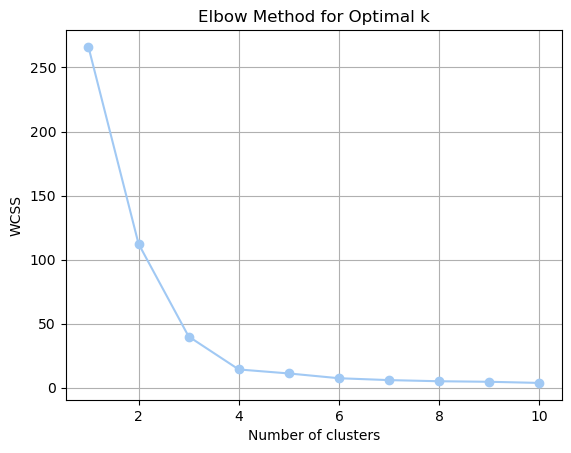

In [69]:
# using elbow method to find the appropriate k value
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


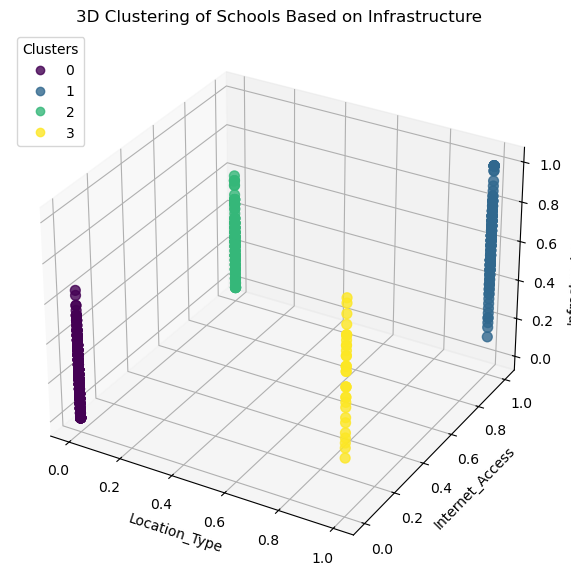

In [70]:
# KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Step 4: 3D Plot using real features
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

ax.set_title("3D Clustering of Schools Based on Infrastructure")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])

# Optional: add cluster legend
legend_labels = [f"Cluster {i}" for i in range(4)]
scatter_legend = ax.legend(
    *scatter.legend_elements(), title="Clusters", loc="upper left"
)
plt.show()

In [71]:
# Assign cluster labels
schools['Cluster'] = labels

# Get count of schools per cluster
cluster_counts = schools['Cluster'].value_counts().sort_index()

# Compute cluster summary (mean of features)
cluster_summary = schools.groupby('Cluster')[features].mean()

# Combine count and summary into one DataFrame
cluster_summary['School_Count'] = cluster_counts

# Reorder columns to put School_Count first
cols = ['School_Count'] + [col for col in cluster_summary.columns if col != 'School_Count']
cluster_summary = cluster_summary[cols]

# final result
print("\nCluster Summary:\n")
print(cluster_summary)

print()
school_clusters = schools[['School_ID', 'Cluster']]
print(school_clusters.head())

# silhouette score
sil_score = silhouette_score(X_scaled, labels)
print(f"\nSilhouette Score: {sil_score:.4f}")




Cluster Summary:

         School_Count  Location_Type  Internet_Access  Infrastructure_Score
Cluster                                                                    
0                 232            0.0              0.0              1.942672
1                 131            1.0              1.0              3.563359
2                 105            0.0              1.0              2.038095
3                  32            1.0              0.0              3.521875

  School_ID  Cluster
0    SCH001        2
1    SCH002        2
2    SCH003        0
3    SCH004        0
4    SCH005        1

Silhouette Score: 0.8132
